Get the data

In [1]:
import os
import pandas as pd
import numpy as np

# Import charting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings thrown by Seaborn
import warnings
warnings.filterwarnings('ignore')

def load_titanic_data(filename, folder="Data"):
    csv_path = os.path.join(folder, filename)
    return pd.read_csv(csv_path)

titanic_train = load_titanic_data("train.csv")
titanic_test = load_titanic_data("test.csv")

titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


So initial lessons to learn: Age has over 150 missing values which is significant in this dataset size Cabin has 22% population which is very poor could initially transform into a new column of has cabin which is binary, not sure if a location from cabin can be gleaned to help predict survival rates based on where in the ship passengers had cabins? Maybe those with cabins could be more likely to have been in them at the time of sinking?

Need to remove PassengerId from training process

Only numerical fields which are related numerical - age and fare. The rest are categorical

In [3]:
204/891 * 100 #Cabin population rate

22.895622895622896

In [4]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


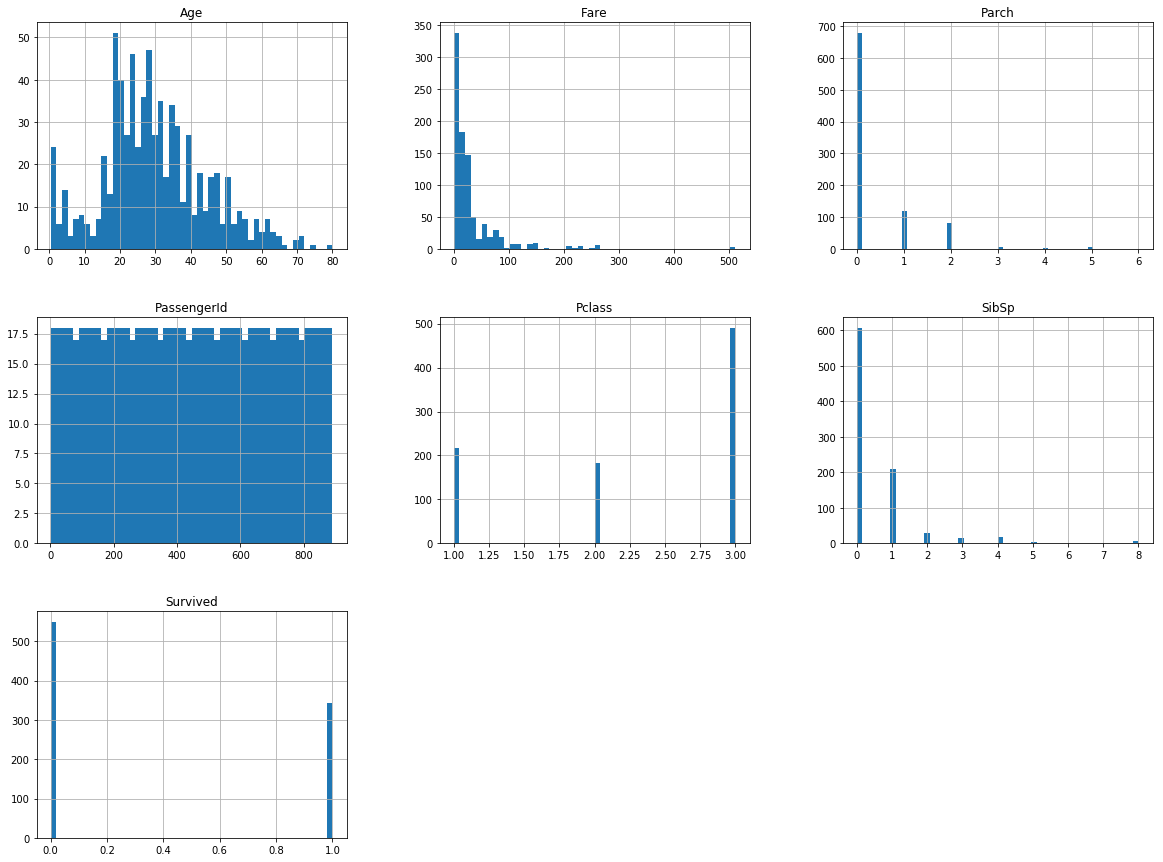

In [5]:
%matplotlib inline
titanic_train.hist(bins=50, figsize=(20,15))
plt.show()

Splitting out a title field from the name seems sensible and setting it's values to true/false
Flagging if a passenger had a Cabin or not - perhaps cabin type matters as well 
Trying to combine Parch and SibSp into a Family feature - saw someone else had done this and sounded sensible
Adding AgeBrackets and FareBrackets

In [110]:
def TitleCategory(data):
    data["Title"] = "Other"
    data.loc[data["Name"].str.contains("Mr.", regex=False), "Title"] = "Mr"
    data.loc[data["Name"].str.contains("Mrs.", regex=False), "Title"] = "Mrs"
    data.loc[data["Name"].str.contains("Master.", regex=False), "Title"] = "Master"
    data.loc[data["Name"].str.contains("Miss.", regex=False), "Title"] = "Miss"
    
def HasCabin(data):
    data["HasCabin"] = data["Cabin"]
    data["HasCabin"] = data["HasCabin"].fillna(value=0)
    data.loc[data["HasCabin"] != 0, "HasCabin"] = 1
    
def CombineFamily(data):
    data["Family"] = data["Parch"] + data["SibSp"]
    
def CabinType(data):
    data["CabinLetter"] = data["Cabin"].str[0]
    
def AgeBracketsCategory(data):
    data["AgeBracket"] = ""
    data.loc[data["Age"] < 3, "AgeBracket"] = "Baby"
    data.loc[(data["Age"] >= 3) & (data["Age"] < 9), "AgeBracket"] = "Child"
    data.loc[(data["Age"] >= 9) & (data["Age"] < 15), "AgeBracket"] = "OldChild"
    data.loc[(data["Age"] >= 15) & (data["Age"] < 22), "AgeBracket"] = "YoungAdult"
    data.loc[(data["Age"] >= 22) & (data["Age"] < 40), "AgeBracket"] = "Adult"
    data.loc[data["Age"] >= 40, "AgeBracket"] = "OldAdult"
    
#Got fare details from: http://www.keyflux.com/titanic/facts.htm 
#However the brackets don't overlap well so making sure all values are covered
def FareBracketsCategory(data):
    data["TicketType"] = ""
    data.loc[data["Fare"] == 0, "TicketType"] = "NoFare"
    data.loc[(data["Fare"] > 0) & (data["Fare"] <= 8), "TicketType"] = "ThirdClass"
    data.loc[(data["Fare"] > 8) & (data["Fare"] <= 30), "TicketType"] = "SecondClass"
    data.loc[(data["Fare"] > 30) & (data["Fare"] < 870), "TicketType"] = "FirstClassBerth"
    #data.loc[(data["Fare"] > 30) & (data["Fare"] <= 75), "TicketType"] = "FirstClassBerthA" #Splitting as there appears to be less survival below 75 fare
    #data.loc[(data["Fare"] > 75) & (data["Fare"] < 870), "TicketType"] = "FirstClassBerthB"
    data.loc[data["Fare"] >= 870, "TicketType"] = "FirstClassParlourSuite" #Doesn't look like any data points hit this but leaving in anyway
    
def SetColumnDefaults(data):
    data.Embarked.fillna('S', inplace=True)
    data.loc[data["Embarked"] == "", "Embarked"] = "S"
    data.Cabin.fillna('Z', inplace=True)
    #data.Age.fillna((data["Age"].median()), inplace=True)
    for title in data.Title.unique():
        data.loc[data["Title"] == title, "Age"] = data.loc[data["Title"] == title, "Age"].fillna(data[titanic_analysis["Title"] == title].Age.median())
    data.Fare.fillna((data["Fare"].median()), inplace=True)
    
def PrepData(data):
    TitleCategory(data)
    SetColumnDefaults(data)
    HasCabin(data)
    CombineFamily(data)
    CabinType(data)
    AgeBracketsCategory(data)
    FareBracketsCategory(data)

In [81]:
from numbers import Number
def plot_survival_per_feature(data, feature, categorical = False):
    if not np.issubdtype(data[feature].dtype, np.number) or categorical == True:
        stacked = data.groupby([feature, 'Survived'])[feature].count().unstack('Survived').fillna(0)
        stacked.plot(kind='bar', stacked=True)
    else:
        grouped_by_survival = data[feature].groupby(data["Survived"])
        survival_per_feature = pd.DataFrame({"Survived": grouped_by_survival.get_group(1),
                                        "didnt_Survive": grouped_by_survival.get_group(0),
                                        })
        hist = survival_per_feature.plot.hist(bins=20, alpha=0.6, stacked = True)
        hist.set_xlabel(feature)
        plt.show()
        
def plot_survival_per_feature_grouping(data, feature, grouping):
    stacked = data.groupby([feature, grouping])[feature].count().unstack(grouping).fillna(0)
    stacked.plot(kind='bar', stacked=True)

Filling for title Mr
Filling for title Mrs
Filling for title Miss
Filling for title Master
Filling for title Other


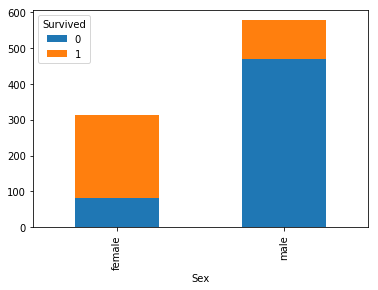

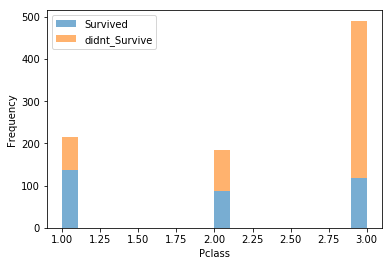

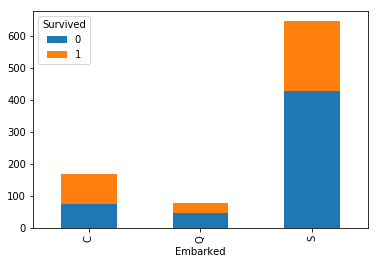

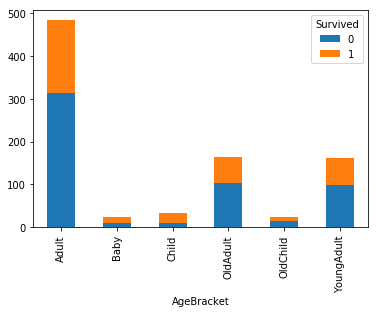

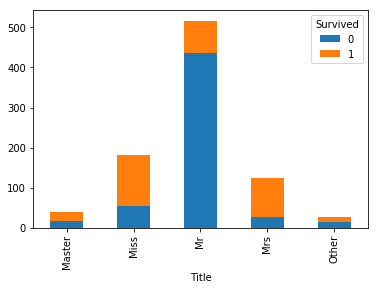

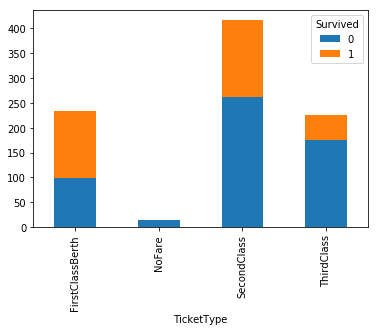

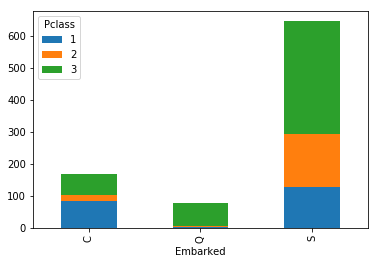

In [66]:
titanic_analysis = titanic_train.copy()
PrepData(titanic_analysis)
plot_survival_per_feature(titanic_analysis, "Sex")
plot_survival_per_feature(titanic_analysis, "Pclass")
plot_survival_per_feature(titanic_analysis, "Embarked")
plot_survival_per_feature(titanic_analysis, "AgeBracket")
plot_survival_per_feature(titanic_analysis, "Title")
plot_survival_per_feature(titanic_analysis, "TicketType")

plot_survival_per_feature_grouping(titanic_analysis, "Embarked", "Pclass")

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'HasCabin',
       'Family', 'CabinLetter', 'AgeBracket', 'TicketType'],
      dtype='object')
          Survived    Pclass       Age     SibSp     Parch      Fare    Family
Survived  1.000000 -0.338481 -0.078698 -0.035322  0.081629  0.257307  0.016639
Pclass   -0.338481  1.000000 -0.353813  0.083081  0.018443 -0.549500  0.065997
Age      -0.078698 -0.353813  1.000000 -0.265577 -0.188081  0.097939 -0.275474
SibSp    -0.035322  0.083081 -0.265577  1.000000  0.414838  0.159651  0.890712
Parch     0.081629  0.018443 -0.188081  0.414838  1.000000  0.216225  0.783111
Fare      0.257307 -0.549500  0.097939  0.159651  0.216225  1.000000  0.217138
Family    0.016639  0.065997 -0.275474  0.890712  0.783111  0.217138  1.000000


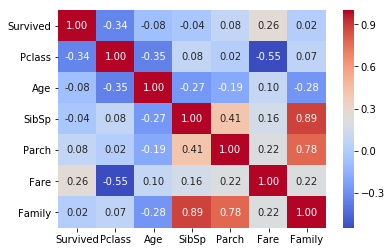

In [67]:
print(titanic_analysis.columns)
print (titanic_analysis[['Survived', 'Pclass','Age', 'SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked', 'Title', 'Family']].corr())

sns.heatmap(titanic_analysis[['Survived', 'Pclass','Age', 'SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked', 'Title', 'Family']].corr(), annot=True, fmt =".2f", cmap="coolwarm")

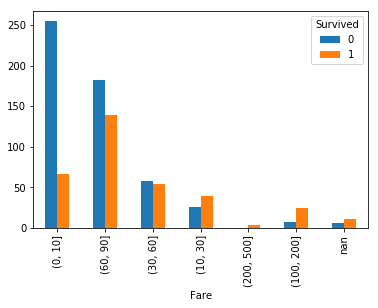

In [82]:
group = pd.cut(titanic_analysis.Fare, [0,10,30,60,90,100,200,500])
piv_fare = titanic_analysis.pivot_table(index=group, columns='Survived', values = 'Fare', aggfunc='count')
piv_fare.plot(kind='bar')

In [84]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

titanic_training = titanic_train.copy()

cat_attribs = ["Sex","Embarked","Pclass","Title","TicketType"]
num_attribs = ["Age", "Fare", "Family","HasCabin"]
print(num_attribs)
print(cat_attribs)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from future_encoders import OneHotEncoder
from sklearn.pipeline import FeatureUnion

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    #('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

train_labels = titanic_training["Survived"]
PrepData(titanic_training)

print(titanic_training.head(10))
print(titanic_training.info())
titanic_prepared = full_pipeline.fit_transform(titanic_training)

['Age', 'Fare', 'Family', 'HasCabin']
['Sex', 'Embarked', 'Pclass', 'Title', 'TicketType']
Filling for title Mr
Filling for title Mrs
Filling for title Miss
Filling for title Master
Filling for title Other
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4           

In [86]:
#Using iris example as a way of throwing a few algorithms at the issue and see how they perform
from pandas.plotting import scatter_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
# Test options and evaluation metric
seed = 42
scoring = 'accuracy'

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('SGD', SGDClassifier()))
models.append(('SVC', SVC()))
models.append(('RF', RandomForestClassifier()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, titanic_prepared, train_labels, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.828327 (0.031093)
LDA: 0.831648 (0.038927)
KNN: 0.828390 (0.041057)
CART: 0.782322 (0.036583)
NB: 0.764345 (0.045566)
SVM: 0.837266 (0.038655)
SGD: 0.689089 (0.122010)
SVC: 0.837266 (0.038655)
RF: 0.795780 (0.025073)


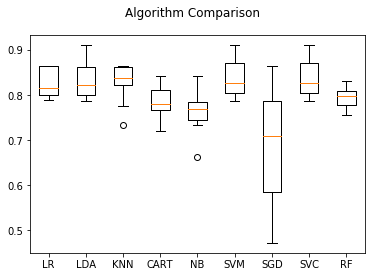

In [87]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From this brief comparison it looks like LR, LDA, KNN, SVM and RF are ok. However with this type of problem a confusion matrix is often useful to see how the precision and recall tradeoff is going. 
The top left  are true  negatives (survived = 0, pred_survived = 0)
The top right are false positives (survived = 0, pred_survived = 1)
Bottom left   are false negatives (survived = 1, pred_survived = 0) 
Bottom right  are true  postivies (survived = 1, pred_survived = 1)

In [88]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

def ConfusionMatrixPrecisionRecall(model, training_data, training_labels):
    cross_val_predictions = cross_val_predict(model, training_data, training_labels, cv=10)
    print(confusion_matrix(training_labels, cross_val_predictions))
    print("Precision:", precision_score(training_labels, cross_val_predictions))
    print("Recall:", recall_score(training_labels, cross_val_predictions))
    print("F1_Score:", f1_score(training_labels, cross_val_predictions))
    

for name, model in models:
    print ("Name:", name)
    print ("Model:", model)
    ConfusionMatrixPrecisionRecall(model, titanic_prepared, train_labels)
    print()
    
#ConfusionMatrixPrecisionRecall(forest_clf, titanic_prepared, train_labels)

Name: LR
Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[[479  70]
 [ 87 255]]
Precision: 0.7846153846153846
Recall: 0.7456140350877193
F1_Score: 0.7646176911544228

Name: LDA
Model: LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
[[488  61]
 [ 89 253]]
Precision: 0.8057324840764332
Recall: 0.7397660818713451
F1_Score: 0.7713414634146342

Name: KNN
Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
[[487  62]
 [ 89 253]]
Precision: 0.8031746031746032
Recall: 0.7397660818713451
F1_Score: 0.7701674277016745

Name: CART
Model: DecisionTreeClassifier(class_weigh

Kind of reinforces what was known but does show som interesting patterns. Originally I had trained with SGD, KNN and Random Forests but I switched to LR after looking at more algorithms and now I'll consider only the best 3 which are:
SVM/SVC
KNN
LR
Now into some hyperparameter turning to get the most out of the algorithms

In [89]:
from sklearn.model_selection import GridSearchCV

param_grid_knn = [
    {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11], 'weights': ["uniform","distance"]},
]

knn_clf = KNeighborsClassifier(n_jobs=-1)
grid_search_knn = GridSearchCV(knn_clf, param_grid_knn, cv=5)
grid_search_knn.fit(titanic_prepared, train_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'weights': ['uniform', 'distance'], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [90]:
param_grid_lr = [
    {'C': [0.1,0.4,0.446,0.4462,0.45,0.455,0.5,0.55,0.6,1]},
]

lr_clf = LogisticRegression()
grid_search_lr = GridSearchCV(lr_clf, param_grid_lr, cv=5)
grid_search_lr.fit(titanic_prepared, train_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.1, 0.4, 0.446, 0.4462, 0.45, 0.455, 0.5, 0.55, 0.6, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [99]:
param_grid_svc = [
    {'C': [0.1,0.5,1.0,2.0,2.5,2.8,3.0,3.2,4.0,5.0], 'kernel' : ["linear", "poly", "rbf"]},
]

svc_clf = SVC()
grid_search_svc = GridSearchCV(svc_clf, param_grid_svc, cv=5)
grid_search_svc.fit(titanic_prepared, train_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.1, 0.5, 1.0, 2.0, 2.5, 2.8, 3.0, 3.2, 4.0, 5.0], 'kernel': ['linear', 'poly', 'rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [100]:
print(grid_search_knn.best_params_)
print(grid_search_knn.best_estimator_)

#cvres = grid_search_knn.cv_results_
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#    print(np.sqrt(mean_score), mean_score, params)

print(grid_search_lr.best_params_)
print(grid_search_lr.best_estimator_)

print(grid_search_svc.best_params_)
print(grid_search_svc.best_estimator_)

{'weights': 'uniform', 'n_neighbors': 9}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
           weights='uniform')
{'C': 0.6}
LogisticRegression(C=0.6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
{'C': 2.8, 'kernel': 'rbf'}
SVC(C=2.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


So now re-train the models and re-evaluate the confusion matrices

In [101]:
knn_clf_best_params = KNeighborsClassifier(n_jobs=-1, n_neighbors=9, weights='uniform')
knn_clf_best_params.fit(titanic_prepared, train_labels)
ConfusionMatrixPrecisionRecall(knn_clf_best_params, titanic_prepared, train_labels)

[[491  58]
 [ 90 252]]
Precision: 0.8129032258064516
Recall: 0.7368421052631579
F1_Score: 0.7730061349693251


In [102]:
lr_clf_best_params = LogisticRegression(C=0.6)
lr_clf_best_params.fit(titanic_prepared, train_labels)
ConfusionMatrixPrecisionRecall(lr_clf_best_params, titanic_prepared, train_labels)

[[483  66]
 [ 89 253]]
Precision: 0.7931034482758621
Recall: 0.7397660818713451
F1_Score: 0.7655068078668684


In [108]:
svc_clf_best_params = SVC(C=2.8, kernel='rbf')
svc_clf_best_params.fit(titanic_prepared, train_labels)
ConfusionMatrixPrecisionRecall(svc_clf_best_params, titanic_prepared, train_labels)

[[493  56]
 [ 89 253]]
Precision: 0.8187702265372169
Recall: 0.7397660818713451
F1_Score: 0.7772657450076806


SVC is still coming out on top so have a go with submitting that file

In [109]:
PrepData(titanic_test)
#titanic_test.Fare.fillna((titanic_test["Fare"].median()), inplace=True)
titanic_test.info()
titanic_test_prepared = full_pipeline.fit_transform(titanic_test)
print(titanic_test_prepared[0])
print(titanic_prepared[0])

print(list(num_attribs), cat_attribs)

test_predictions = svc_clf_best_params.predict(titanic_test_prepared)
titanic_test_output = [titanic_test, test_predictions]
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": test_predictions
    })
print(submission)
submission.to_csv('titanic_predictions_SVC_C2p8_K_RBF.csv', index=False)

Filling for title Mr
Filling for title Mrs
Filling for title Miss
Filling for title Master
Filling for title Other
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 17 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          418 non-null object
Embarked       418 non-null object
Title          418 non-null object
HasCabin       418 non-null int64
Family         418 non-null int64
CabinLetter    418 non-null object
AgeBracket     418 non-null object
TicketType     418 non-null object
dtypes: float64(2), int64(6), object(9)
memory usage: 55.6+ KB
[ 0.38673757 -0.49741333 -0.5534426   0.          0.          1.
  0.          1.          0.          0.          0.         

This got me 0.78947 and ranked 3117 on Kaggle out of ~9000 so not bad! This is after much messing about which is hidden in other files. Next steps would be to revisit the data preparation phase and look more closely at what can be done there. For instance there were a large number of missing ages and doing median on them all doesn't feel right. Should instead split by title or something to get a better estimate for the missing values. My aim is 80% or better so I'm not done with this one yet! It's been very useful for learning key parts about data preparation and model selection/tuning. I need to understand more about the anyalysis phase and how to derive new fields/values in a better way.